In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import sys
import random
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import pickle

In [2]:
# dataset
from dataset.dataset import Branin_DatasetHandler
dataset = Branin_DatasetHandler(train_path="./storage/branin/data_train.csv", train_fraction=1.0, device=device)

# test dataset
print(dataset.train_data.X_data, dataset.train_data.y_data)
print(dataset.train_data[:])
train_loader, test_loader = dataset.get_dataloader()
for X, y in train_loader:
    print(X, y)

tensor([[ 0,  7],
        [ 1, 41],
        [43,  0],
        [83, 84]]) tensor([-272.7960, -122.4223,  -25.6283, -141.9208])
(tensor([[0.0000, 0.0700],
        [0.0100, 0.4100],
        [0.4300, 0.0000],
        [0.8300, 0.8400]]), tensor([0.0000, 0.6084, 1.0000, 0.5295]))
tensor([[0.0100, 0.4100],
        [0.0000, 0.0700],
        [0.4300, 0.0000],
        [0.8300, 0.8400]]) tensor([0.6084, 0.0000, 1.0000, 0.5295], dtype=torch.float64)


In [3]:
# Load Hydra config in notebooks
# https://github.com/facebookresearch/hydra/blob/main/examples/jupyter_notebooks/compose_configs_in_notebook.ipynb
import os
from hydra import initialize_config_dir, compose
from omegaconf import OmegaConf

abs_config_dir=os.path.abspath("config/")
with initialize_config_dir(version_base=None, config_dir=abs_config_dir):
    config_logger = compose(config_name="logger.yaml", overrides=[])
    # print(OmegaConf.to_yaml(env_config))
    print(config_logger)

{'do': {'online': True, 'times': True}, 'ckpts': {'policy': {'period': 5000}, 'regressor': {'period': 10}}, 'train': {'period': 1}, 'test': {'period': -1, 'n': 1, 'first_it': True, 'kde': {'bandwidth': 0.1, 'kernel': 'gaussian'}}, 'oracle': {'period': -1, 'k': [1, 10, 100]}, 'logdir': {'root': './logs', 'ckpts': 'ckpts', 'data': 'data', 'overwrite': True}, 'lightweight': False, 'progress': True, 'debug': False, 'project_name': 'MF-AL-GFN', 'tags': ['branin', 'sf']}


In [4]:
from utils.logger import Logger
logger = Logger(
    config=OmegaConf.create(), 
    **config_logger
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: christina-humer. Use `wandb login --relogin` to force relogin


In [5]:
# oracle
from gflownet.proxy.box.branin import Branin
oracle = Branin(fidelity=1, do_domain_map=True, device=device, float_precision=64)

# test oracle
grid_size = 100
states = torch.tensor([[ 0,  7],
        [ 1, 41],
        [43,  0],
        [83, 84]])
states = torch.tensor(states/grid_size).to(device)
oracle(states.clone())

/tmp/ipykernel_2070751/2068918033.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  states = torch.tensor(states/grid_size).to(device)


tensor([ -35.8619, -185.1583, -282.1307, -167.8297], device='cuda:0',
       dtype=torch.float64)

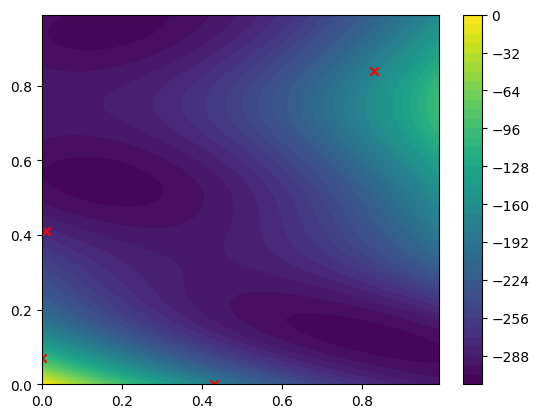

In [6]:
# plot oracle function
import numpy as np
import matplotlib.pyplot as plt
import torch
xi = np.arange(0,1,1/grid_size)
yi = np.arange(0,1,1/grid_size)
grid = np.array(np.meshgrid(xi,yi))
grid_flat = torch.tensor(grid.T, dtype=torch.float).reshape(-1,2).to(device)
res = oracle(grid_flat).to("cpu")
fig, ax = plt.subplots(nrows=1)
# ax.matshow(res)
# https://matplotlib.org/stable/gallery/images_contours_and_fields/irregulardatagrid.html#sphx-glr-gallery-images-contours-and-fields-irregulardatagrid-py
cntr = ax.contourf(xi, yi, res.reshape(int(len(res)**(1/2)),int(len(res)**(1/2))), levels=50)
fig.colorbar(cntr, ax=ax)
plt.scatter(x=states[:,0].cpu(), y=states[:,1].cpu(), c="red", marker="x")
plt.show()

In [10]:
# # environment
# import config
# train = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# test = config.env.BufferSpec(
#     path="~/scratch/datasets/grid/corners_d2l3_r0.csv",
#     seed=167,
#     n=1000,
# )
# buffer = config.env.Buffer(train=train, test=test)
# config_env = config.env.Grid_Env(
#     buffer, 
#     min_step_len=1,
#     max_step_len=1,
#     cell_min=-1,
#     cell_max=1
# )

# from environment.grid_env import GridEnv
# env = GridEnv(**config_env.__dict__)